# Лабораторная работа 9
## Задание:
1. Создайте свой датасет для задачи бинарной классификации. В нем должно быть как можно больше изображений, содержащих объект (позитивные семплы), и не содержащих его (негативные семплы). Для увеличения количества данных используйте аугментацию. Используйте фотографии реально существующих объектов. Можете использовать уже существующий датасет. Структурируйте датасет, как это разбирали на одном из предыдущих занятий.
2. Используйте архитектуру сети VGGNet, представленную в работе. Не забудьте скорретировать формат тензора для входного слоя сети.
3. Визуализируйте архитектуру сети
4. При необходимости загрузите веса предобученной модели VGGNet, используя файл с весами h5. Это необходимо, если точность модели не увеличивается, или модель дает ошибку во время обучения.
5. Обучите модель сети на вашем датасете и определите точность классификации на тестовых данных.
6. Визуализируйте метрики точности при обучении сети
7. Проверьте прогностическую способность модели на одном семпле
8. Создайте confusion matrix для модели и проанализируйте результат.
## Подготовка окружения для генераций изображения

In [2]:
# 1) Импорт всех необходимых библиотек
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from rich.table import Table
from gz_utils_balcon import EntityManager
import rclpy
from rclpy.wait_for_message import wait_for_message
from cv_bridge import CvBridge
from sensor_msgs.msg import Image
import time
import copy
import math
import threading
import random
#Rich
from rich.progress import track

# 2) Инциализация `rclpy` и создания node для наблюдения за сообщениями
if not rclpy.ok():
    rclpy.init()
    node = rclpy.create_node("simple_node")
    # thread = threading.Thread(target = rclpy.spin, args = (node,), daemon = True)
    # thread.start()




# 3) Создания CvBridge
bridge = CvBridge()

# 4) Создания экземпляра EntityManager для мира "default"
emg = EntityManager("default")


# 5) Функция для получения изображения
def get_msg():
    msg = wait_for_message(Image,node,"/camera/rgb/image_raw",time_to_wait=20000)
    if msg[0] == False:
        raise TimeoutError
    else:
        return msg


def get_image():
    msg = get_msg()
    img_rgb = bridge.imgmsg_to_cv2(msg[1])
    return img_rgb[100:375,150:500]

# 6) Функция для визуализаций ряда изображений
def vusial_imgs(ls_img):
    plt.figure(figsize=(12,10))
    for i in range(len(ls_img)):
        plt.subplot(4,4,i+1)
        plt.imshow(ls_img[i])


## Ход работы
### 1. Часть генерация изображения и сохранения их
Сгенерирум 16 изображений с случайным углом поворота для тренеровки и 8 изображений для тестов

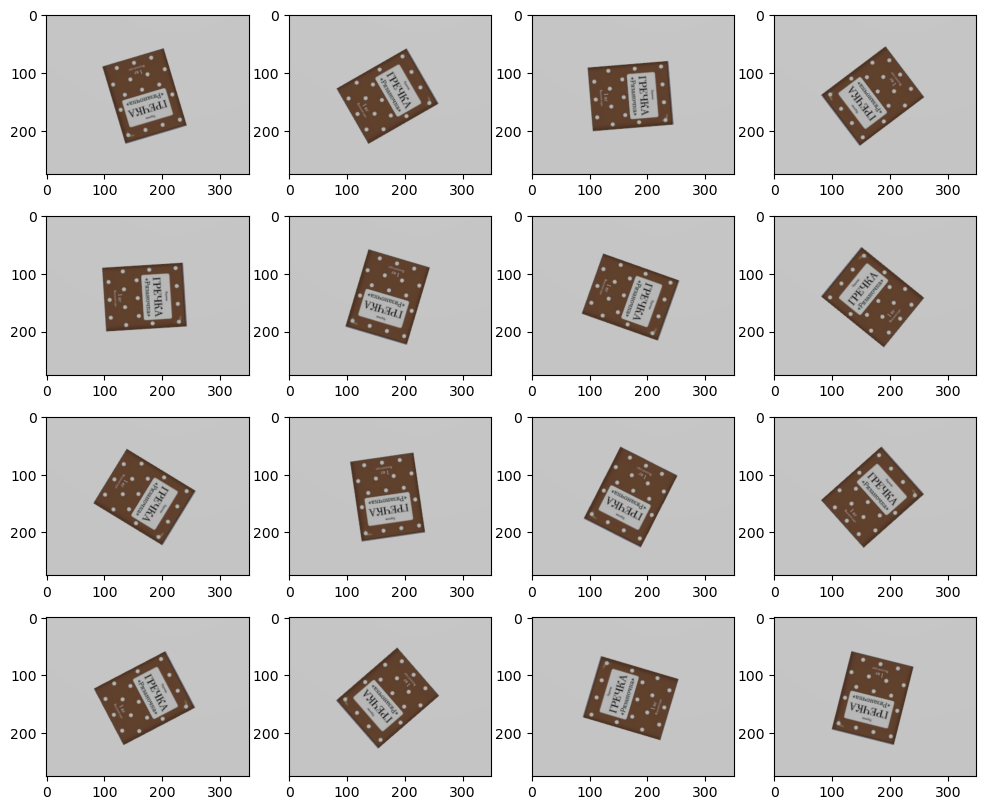

In [4]:
cereal_imgs_train = []

emg.delete_entity(["unknow"])
for i in range(16):
    yaw = random.random() * 2 * math.pi
    emg.create_entity("cereal.sdf", yaw = yaw)
    img1= get_image()
    emg.delete_entity(["unknow"])
    cereal_imgs_train.append(img1)
    time.sleep(0.1)

cereal_imgs_test = []
emg.delete_entity(["unknow"])
for i in range(8):
    yaw = random.random() * 2 * math.pi
    emg.create_entity("cereal.sdf", yaw = yaw)
    img1= get_image()
    emg.delete_entity(["unknow"])
    cereal_imgs_test.append(img1)
    time.sleep(0.1)

vusial_imgs(cereal_imgs_train)

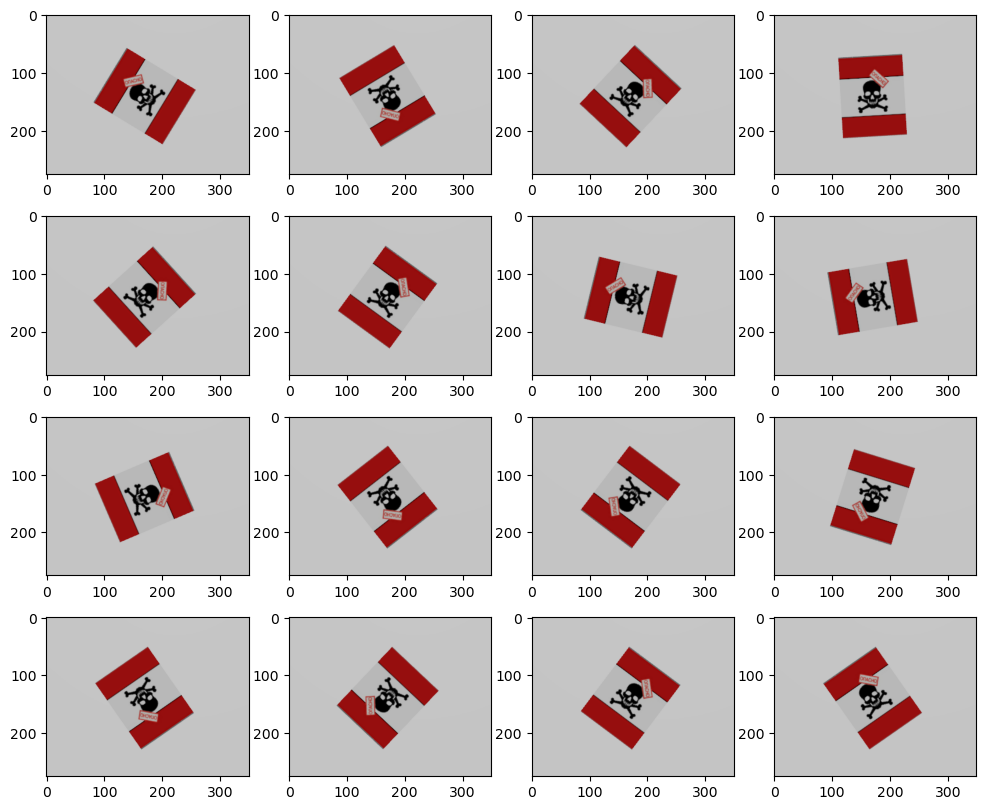

In [5]:
poison_imgs_train = []

emg.delete_entity(["unknow"])
for i in range(16):
    yaw = random.random() * 2 * math.pi
    emg.create_entity("poison.sdf", yaw = yaw)
    img1= get_image()
    emg.delete_entity(["unknow"])
    poison_imgs_train.append(img1)
    time.sleep(0.1)

poison_imgs_test = []
for i in range(8):
    yaw = random.random() * 2 * math.pi
    emg.create_entity("poison.sdf", yaw = yaw)
    img1= get_image()
    emg.delete_entity(["unknow"])
    poison_imgs_test.append(img1)
    time.sleep(0.1)
vusial_imgs(poison_imgs_train)

In [ ]:
for i in range(len(poison_imgs_train)):
    cv.imwrite(f"dataset/training/poison/img{i}.jpeg", poison_imgs[i])

for i in range(len(cereal_imgs_train)):
    cv.imwrite(f"dataset/training/cereal/img{i}.jpeg", cereal_imgs[i])

for i in range(len(poison_imgs_test)):
    cv.imwrite(f"dataset/val/poison/img{i}.jpeg", poison_imgs[i])

for i in range(len(cereal_imgs_test)):
    cv.imwrite(f"dataset/val/cereal/img{i}.jpeg", cereal_imgs[i])


### Часть 2 Исползования датасета и обучения модели

In [2]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/training/
   creating: dataset/training/poison/
  inflating: dataset/training/poison/img1.jpeg  
  inflating: dataset/training/poison/img0.jpeg  
  inflating: dataset/training/poison/img2.jpeg  
  inflating: dataset/training/poison/img3.jpeg  
  inflating: dataset/training/poison/img4.jpeg  
  inflating: dataset/training/poison/img5.jpeg  
  inflating: dataset/training/poison/img6.jpeg  
  inflating: dataset/training/poison/img7.jpeg  
  inflating: dataset/training/poison/img8.jpeg  
  inflating: dataset/training/poison/img9.jpeg  
  inflating: dataset/training/poison/img10.jpeg  
  inflating: dataset/training/poison/img11.jpeg  
  inflating: dataset/training/poison/img12.jpeg  
  inflating: dataset/training/poison/img13.jpeg  
  inflating: dataset/training/poison/img14.jpeg  
  inflating: dataset/training/poison/img15.jpeg  
   creating: dataset/training/.ipynb_checkpoints/
   creating: dataset/training/cereal/
  inflati

In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D,Conv2D, MaxPool2D,Input
import tensorflow as tf
from keras.utils import to_categorical
from keras import regularizers
from keras.models import Sequential, load_model
from keras.optimizers import Adam

In [238]:
traindata = ImageDataGenerator()
testdata = ImageDataGenerator()

train_data = traindata.flow_from_directory("dataset/training", color_mode='rgb')
test_data = testdata.flow_from_directory("dataset/val", color_mode='rgb')

x_train, y_train = next(train_data)
x_test, y_test = next(test_data)
y_train = y_train[:,1:]
y_test = np.array(y_test[:,1:])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train  /= 255
x_test /= 255

def convert_bgr2rgb_and_resize(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(32,32))
  return img

def transform(image):
    image =  image[:,::-1]
    return image


x_train = list(map(convert_bgr2rgb_and_resize, x_train))
x_test = list(map(convert_bgr2rgb_and_resize, x_test))
print(f"Размер исходного датасета: {len(x_train)}/{len(y_train)}")

x_train_transform = list(map(transform,x_train))
x_test = np.array(list(map(transform,x_test)))

x_train = np.concatenate((x_train, x_train_transform))
y_train = np.concatenate((y_train, y_train))

print(f"Размер нынешнего датасета: {len(x_train)}/{len(y_train)}")

Found 32 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Размер исходного датасета: 32/32
Размер нынешнего датасета: 64/64


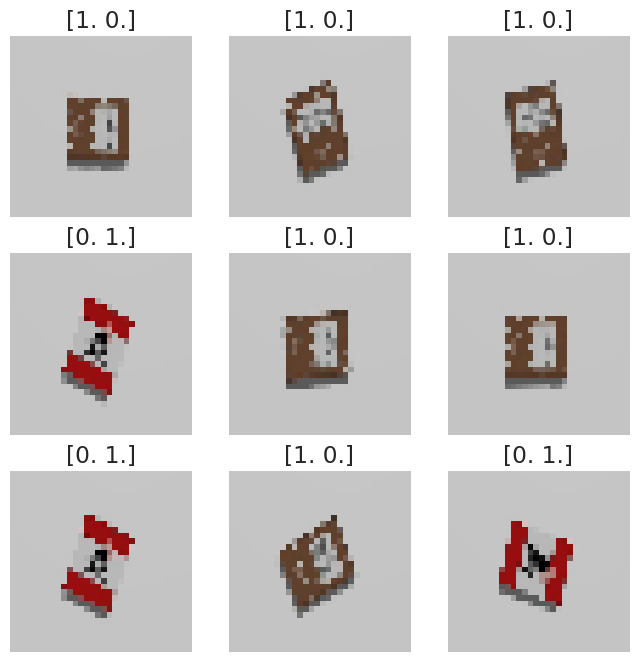

In [239]:
index_plot = 1
plt.figure(figsize=(8,8))
for i in range(9):
  img, label = x_train[i], y_train[i]
  z = label
  plt.subplot(3,3,index_plot)
  plt.axis('off')
  plt.title(label)
  plt.imshow(img)
  index_plot+=1

#### 2. Используйте архитектуру сети VGGNet, представленную в работе. Не забудьте скорретировать формат тензора для входного слоя сети.

In [233]:
from tensorflow.keras.models import Sequential, Model


In [240]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [272]:



x = vgg_model.get_layer('block1_conv1').output
x = vgg_model.get_layer('block1_conv2') (x)
x = vgg_model.get_layer('block1_pool') (x)

x = vgg_model.get_layer('block2_conv1') (x)
x = vgg_model.get_layer('block2_conv2') (x)
x = vgg_model.get_layer('block2_pool') (x)

x = vgg_model.get_layer('block3_conv1') (x)
x = vgg_model.get_layer('block3_conv2') (x)
x = vgg_model.get_layer('block3_conv3') (x)
x = vgg_model.get_layer('block3_pool') (x)

x = vgg_model.get_layer('block4_conv1') (x)
x = vgg_model.get_layer('block4_conv2') (x)
x = vgg_model.get_layer('block4_conv3') (x)
x = vgg_model.get_layer('block4_pool') (x)

x = vgg_model.get_layer('block5_conv1') (x)
x = vgg_model.get_layer('block5_conv2') (x)
x = vgg_model.get_layer('block5_conv3') (x)
x = vgg_model.get_layer('block5_pool') (x)

x = Conv2D(64, 3, activation = 'relu', padding = 'same') (x)
x = Flatten() (x)
x = Dropout(0.5) (x)
x = Dense(2, activation="softmax") (x)
model = Model(inputs = vgg_model.input, outputs = x)

for layer in model.layers[:19]:
  layer.trainable = False
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer_35 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
conv2d_193 True
flatten_33 True
dropout_136 True
dense_63 True


In [273]:

model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


#### 3. Визуализируйте архитектуру сети

In [274]:
model.summary()


Model: "functional_892"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_193 (Conv2D)                  │ (None, 1, 1, 64)            │         294,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_33 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,009,794 (57.26 MB)

 Trainable params: 295,106 (1.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### 5. Обучите модель сети на вашем датасете и определите точность классификации на тестовых данных.

In [275]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='auto')
history = model.fit(x_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4700 - loss: 0.7181 - val_accuracy: 0.4615 - val_loss: 0.6839
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6971 - loss: 0.6184 - val_accuracy: 0.5385 - val_loss: 0.6595
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7598 - loss: 0.5355 - val_accuracy: 0.8462 - val_loss: 0.5586
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8433 - loss: 0.4839 - val_accuracy: 0.8462 - val_loss: 0.4777
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9269 - loss: 0.4379 - val_accuracy: 0.8462 - val_loss: 0.4266


#### 6. Визуализируйте метрики точности при обучении сети

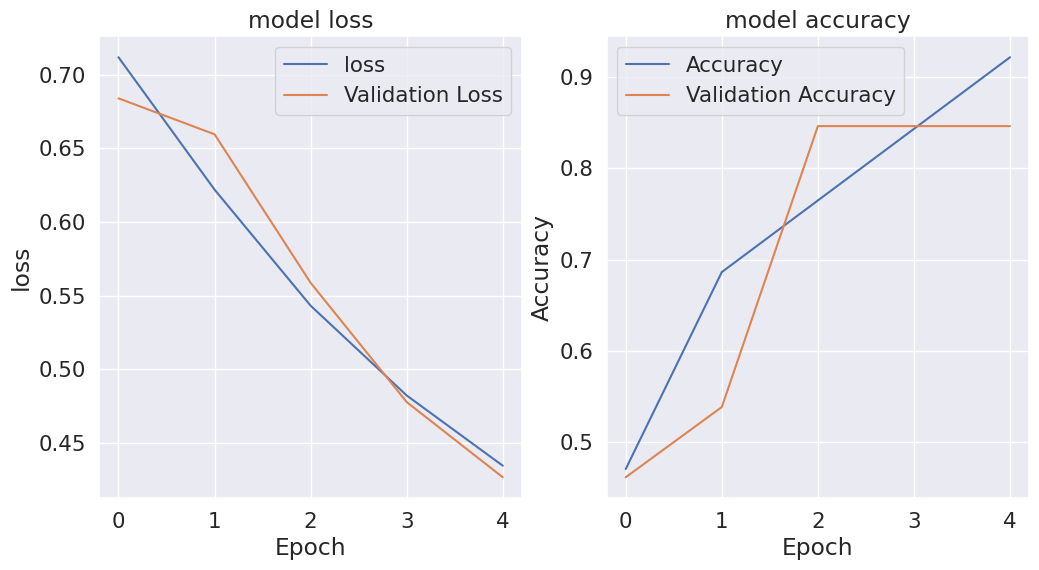

In [292]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.title("model loss")
plt.legend(["loss","Validation Loss"])

plt.subplot(1,2,2)
plt.title("model accuracy")

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])

In [277]:
model.evaluate(x_test,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9375 - loss: 0.4251


[0.425065815448761, 0.9375]

#### 7. Проверьте прогностическую способность модели на одном семпле

In [278]:
class_names =['Гречка','Яд']

In [279]:
sample = x_train[0]
sample_index = np.argmax(y_train[0])

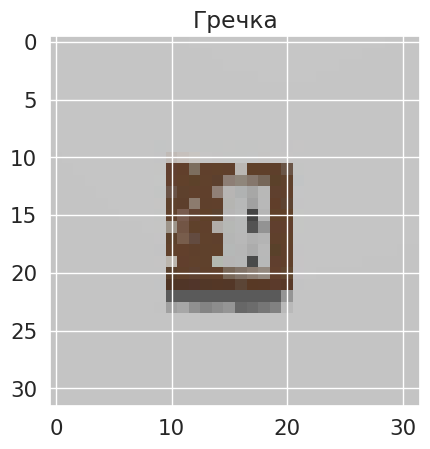

In [280]:
plt.title(class_names[sample_index])
plt.imshow(sample)

In [281]:
sample = np.expand_dims(sample, axis=0)
prediction = model.predict(sample)
print(class_names[np.argmax(prediction)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Гречка


#### 8. Создайте confusion matrix для модели и проанализируйте результат."

In [282]:
prediction = model.predict(x_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step 


In [283]:
import numpy as np
a  = np.array([[0,1,0,0],[1,0,0,0],[0,0,0,1]])
print('np.argmax(a, axis=1): {0}'.format(np.argmax(a, axis=1)))

np.argmax(a, axis=1): [1 0 3]


In [284]:
y_train_int = np.argmax(y_train, axis = 1)
prediction_int = np.argmax(prediction, axis = 1)

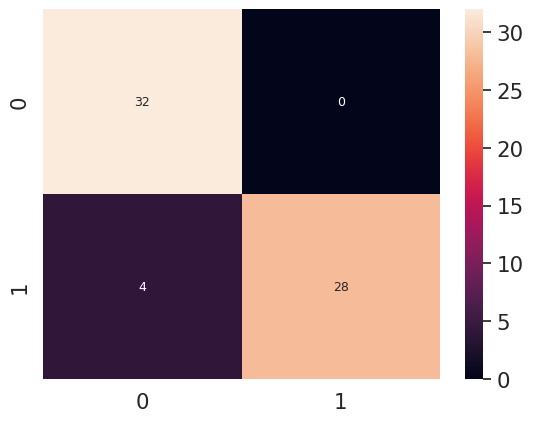

In [285]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

label_names = [i for i in range(2)]
cmx = confusion_matrix(y_train_int, prediction_int, labels = label_names)
df_cm = pd.DataFrame(cmx)
sns.set(font_scale = 1.4)
sns.heatmap(df_cm,annot=True, annot_kws={"size":9},fmt="d")
plt.show()